# Dataset Creation

## Aim
Create a dataset of proteins related and not with cell cycle for **future analysis**.

---

## Necessary Downloads
Before starting, be sure to have downloaded the following material.

### 1. MSigDB Gene Sets (Human)
Download the entire MSigDB for **Human** in **JSON** format (`Human Gene Set JSON file set (ZIPped)`).
- **Link**: [https://www.gsea-msigdb.org/gsea/downloads.jsp](https://www.gsea-msigdb.org/gsea/downloads.jsp)

### 2. UniProt Human Proteome
Download the list of all **HUMAN proteins** (UniProt human proteome - **UP000005640**).
- **Link (Website)**: [https://www.uniprot.org/proteomes/UP000005640](https://www.uniprot.org/proteomes/UP000005640)
- **Programmatic Download (Terminal)**:

```bash
wget -O human_proteome.tsv.gz "[https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640](https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640))"
gunzip human_proteome.tsv.gz
```

### 3. UniProt Gene-Protein mapping

Both for building Uniref50 cluster and getting protein-gene mapping.

[UniProt protein-gene Mapping](https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz)


<!-- ### 3. UniRef50 Clusters

#### A. Initial Programmatic Download (Partial)
This method retrieves all clusters with at least one human protein, but is a **subsample** of the full UniRef50.
- **Link (Website)**: [https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29](https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29)
- **Programmatic Download (Terminal)**:
    - **ATTENTION**: This call retrieves all clusters with at least 1 human protein, *not* just the human proteins themselves.

```bash
curl -o uniref50_human.tsv.gz "[https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606](https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606)))"
gunzip uniref50_human.tsv.gz
``` -->

<!-- ### 5. BioMart Gene-Protein mapping

Download BioMart gne-protein mapping, besure to include **Gene Name** and **Transcript Name**.
[link](https://www.ensembl.org/biomart/martview/3aaaf734b93facdfad8207234204cc31) --> 


# Differences

- OK: do not care about crucial for mitosis, but not for controlling whether or when mitosis happens. (ex spidnle) They are executors, not decision-makers.
    - recome cell cycle is too broad!!!
    - My concern is that including genes encoding structural machinery might introduce too much variability for the model to learn effectively.
- OK: not use as negative proteisn in the same lcuster as postive
    - Cluster UniRef50_Q5VXH4 contains proteins [Q5VXH4, A3QJZ7, Q5VWM4]
    - Say 2 are labeled positive, 1 is labeled negative
    - ut this isn't learning cell-cycle function — it's learning "this cluster tends to be cell-cycle"
    - his creates an impossible learning problem. The model can't possibly learn that these should have different labels because there's almost no signal in the embeddings to distinguish them.
- OK: do not sample psotve genes, but take all
- OK: aplit by  cluster in train/test -- no dataleackage
- change egative class:
    - Negative = "protein annotated to genes known to be involved in non-cell-cycle pathways"
        - For example: neuronal proteins, muscle-specific proteins, proteins involved in cell death/apoptosis, structural proteins
        - "neuronal development," "muscle differentiation," "extracellular matrix"
    - or housekeep genes

CONCENRS
- false negative: : Just because a gene wasn't in your MSigDB search doesn't mean the protein isn't involved in cell-cycle.
- Genes that appear in ambiguous frequency aren't necessarily non-cell-cycle



# Hyperparameters

In [1]:
import json
import os
import re
import pandas as pd
import numpy as np
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import random
import torch

import utils.dataset_functions as dataf

# Initializations
SEED=42
random.seed(SEED)
np.random.seed(SEED)

# Directory containing MSigDB JSON files
JSON_DIR = "/home/gdallagl/myworkdir/data/MSigDB/msigdb_v2025.1.Hs_json_files_to_download_locally"

# cellcycel geensets saving apth
CELL_CYCLE_CSV_PATH = "/home/gdallagl/myworkdir/data/MSigDB/cell_cycle_genesets.csv"

# Guaranted genes list
GUARANTEED_GENES_PATH = "/home/gdallagl/myworkdir/data/MSigDB/julies_cycling_signatures_cancer.tsv"

# Updated keywords pattern with word boundaries to avoid false matches
KEYWORDS_PATTERN = "|".join([
    "_PROLIFERATION_", #avoid "proliferative" "proliferator"
    "_CYCLING",  # avoid "recycling"
    "CELL_CYCLE",
    "_CC_", "_G1_", "_S_PHASE_", "_G2_", "_M_PHASE_", # avoid "aCCumbens"
    "MITOSIS", "MITOTIC",
    "CDK",
    "CHECKPOINT"
])

# Exclusion pattern
EXCLUSION_PATTERN = r"MEIOTIC|MEIOSIS|FATTY_ACID_CYCLING_MODEL"


# KEYWORDS_PATTERN = "|".join([
#     # Key regulatory phrases
#     "_CELL_CYCLE_CHECKPOINT",
#     "CELL_CYCLE_REGULATION",
#     "CELL_CYCLE_CONTROL",

#     "HALLMARK_E2F_TARGETS", 
#     " HALLMARK_G2M_CHECKPOINT",
#     # Core regulators
#     "CDK", "_CYCLIN",

#     # Transitions
#     "_G1_S", "G1_S_", "G2_M", "_S_PHASE_", "M_PHASE", "MITOTIC_CHECKPOINT"
# ])
# # Exclusion pattern
# EXCLUSION_PATTERN = r"MEIOTIC|MEIOSIS|FATTY_ACID_CYCLING_MODEL|CDK5|CANCER|APOPTOSIS|RECYCLING|SPINDLE|KINETOCHORE|CYTOKINESIS|CENTROSOME|KEGG_MEDICUS_PATHOGEN|KEGG_MEDICUS_VARIANT|KEGG_MEDICUS_REFERENCE|PREDICTED|HE_LIM_SUN_FETAL_LUNG|MALIGNANT|MORF_CDK2"

# Human proteome path
HUMAN_PROTEOME_PATH = "/home/gdallagl/myworkdir/data/UniRef50/human_proteome.tsv"

# mapping protein-gene apth
MAPPING_PATH = "/home/gdallagl/myworkdir/ESMSec/data/UniRef50/HUMAN_9606_idmapping.dat"

# Minimum frequency threshold for filtering ambiguous genes
MIN_FREQ_AMBIGOUS = 2

# min number of postive samples per positive cluster
MIN_SAMPLE_N_POSITIVE = 2

# multiplocative factor to kwno how much morenegative class to sample
NEGATIVE_CLASS_MULT = 3

# if use as postive class only the guaranted genes
ONLY_GUARANTEED = False
only_guaranteed = "only-guaranteed_" if ONLY_GUARANTEED else ""

# id samplepostive class or take all postive egens
TAKE_ALL_POSITIVE_GENES = False

# If use only curated (swissprot) proteins or not
ONLY_REVIEWED_PROTEINS = True

# savifn csv datset
FINAL_DATASET_PATH = f"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/dataset-cell-cycle_{only_guaranteed}{MIN_SAMPLE_N_POSITIVE}:{NEGATIVE_CLASS_MULT}.csv"
print(FINAL_DATASET_PATH)

# Autorelaod
%load_ext autoreload
%autoreload 2

/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/dataset-cell-cycle_2:3.csv


# Find allowed protein for the analyss

Focus only on:
- human
- reviwed
- no isoforms

In [89]:
proteome_uniprot = pd.read_csv(HUMAN_PROTEOME_PATH, sep="\t")

# ONLY Human 
    # csv file alredy fitered by species

# ONLY swissprot
if ONLY_REVIEWED_PROTEINS:
    proteome_uniprot_reviewed = proteome_uniprot[proteome_uniprot.Reviewed == "reviewed"].copy()
    print("reviewed shape: ", proteome_uniprot_reviewed.shape)

# No isofrom, use canonical protein
proteome_uniprot_reviewed['IsIsoform'] = proteome_uniprot_reviewed['Entry'].str.contains(r'-\d+$')
n_isoforms = proteome_uniprot_reviewed['IsIsoform'].sum()
n_total = len(proteome_uniprot_reviewed)
print(f"Isoforms: {n_isoforms} / {n_total} ({n_isoforms/n_total:.2%})")

# Define proteins to use in the follwing analasys
allowed_proteins = set(proteome_uniprot_reviewed.Entry)
print("Number allowed proteins: ", len(allowed_proteins))
allowed_proteins

reviewed shape:  (20405, 7)
Isoforms: 0 / 20405 (0.00%)
Number allowed proteins:  20405


{'O14633',
 'P53708',
 'Q99946',
 'Q16819',
 'P09382',
 'Q6IMN6',
 'Q86SG4',
 'A0A0C4DH42',
 'Q9BUG6',
 'P52740',
 'Q8N414',
 'Q3MII6',
 'A8MT70',
 'A6NNP5',
 'Q96A37',
 'Q86U28',
 'O95789',
 'O75891',
 'Q8TAM1',
 'Q92537',
 'Q6P9F7',
 'Q9Y6N6',
 'P17936',
 'O94921',
 'Q8IY18',
 'Q6ICI0',
 'O75356',
 'Q9UH90',
 'P08779',
 'P61086',
 'P46952',
 'Q8TDL5',
 'O15479',
 'P01011',
 'Q9NPA8',
 'P12270',
 'Q14439',
 'Q8WUY9',
 'P49758',
 'Q9BW83',
 'A0AV02',
 'P07306',
 'Q9NS00',
 'Q05DH4',
 'O75460',
 'Q13591',
 'Q8N699',
 'Q9H8X2',
 'O75934',
 'Q8IUC2',
 'Q6P2D0',
 'Q9BXV9',
 'P54289',
 'Q9Y6B6',
 'P62837',
 'Q86Y01',
 'Q01196',
 'Q3MJ40',
 'Q86VR8',
 'Q5HYW3',
 'Q9H255',
 'P0C7U0',
 'A0A087X0M5',
 'Q15042',
 'A6NEQ0',
 'Q9H9K5',
 'Q9Y333',
 'Q96H78',
 'P11117',
 'Q6MZQ0',
 'Q3SY69',
 'P05113',
 'P26641',
 'Q9UHK0',
 'Q8NA29',
 'Q86YW9',
 'Q9UNN5',
 'P30050',
 'P01602',
 'Q9H0H0',
 'Q8N8U3',
 'Q8IYR0',
 'O60645',
 'P82673',
 'A6NJY4',
 'Q92636',
 'Q86VS3',
 'Q8N257',
 'O94910',
 'Q14094',
 '

In [3]:
# # ATTENTION: same protein can have mutliple genes
# print("Gens mapping to Q9P1J3 -->", proteome_uniprot[proteome_uniprot["Entry"] == "Q9P1J3"]["Gene Names"].values)

# # ATTENTION: soem proteins can have Nan geens
# display(proteome_uniprot[proteome_uniprot["Entry"] == "Q9N2K0"])

# # ATTNETION: are there ducplatd proteins
# print("number duplicated proteins:", proteome_uniprot_reviewed.Entry.duplicated().sum())


# Select pathways related to cell cycle

Read the MSigDB and select all pathways with keyword related to field of interest.

In [90]:
### 1) Transform jsons into df
df_genesets = dataf.load_json_folder_to_df(JSON_DIR)
df_genesets = df_genesets.drop_duplicates(subset=['set_name'], keep='first')
display(df_genesets.head(2)); print(df_genesets.shape)

,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file
0,MIR153_5P,C3:MIR:MIRDB,M30412,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[A1CF, AAK1, AASDHPPT, ABCE1, ABHD2, ABI2, ACB...",[],[],c3.mir.mirdb.v2025.1.Hs.json
1,MIR8485,C3:MIR:MIRDB,M30413,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[AAK1, ABHD18, ABL2, ABLIM1, ACVR1, ACVR2B, AC...",[],[],c3.mir.mirdb.v2025.1.Hs.json


(35134, 11)


In [91]:
### 2) Select only geneset related to interested fiedl
mask_include = df_genesets["set_name"].str.contains(KEYWORDS_PATTERN, case=False, regex=True)
mask_exclude = df_genesets["set_name"].str.contains(EXCLUSION_PATTERN, case=False, regex=True)
genesets_cell_cycle = df_genesets[mask_include & ~mask_exclude].copy()

# save
genesets_cell_cycle.to_csv(CELL_CYCLE_CSV_PATH)

print(genesets_cell_cycle.shape)
list(genesets_cell_cycle['set_name'].sort_values())

(291, 11)


['ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_DN',
 'ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_UP',
 'BENPORATH_CYCLING_GENES',
 'BIOCARTA_CDK5_PATHWAY',
 'BIOCARTA_G1_PATHWAY',
 'BIOCARTA_G2_PATHWAY',
 'BOYAULT_LIVER_CANCER_SUBCLASS_G1_DN',
 'BOYAULT_LIVER_CANCER_SUBCLASS_G1_UP',
 'CHIANG_LIVER_CANCER_SUBCLASS_PROLIFERATION_DN',
 'CHIANG_LIVER_CANCER_SUBCLASS_PROLIFERATION_UP',
 'DONATO_CELL_CYCLE_TRETINOIN',
 'EGUCHI_CELL_CYCLE_RB1_TARGETS',
 'FISCHER_G1_S_CELL_CYCLE',
 'FISCHER_G2_M_CELL_CYCLE',
 'FUJIWARA_PARK2_HEPATOCYTE_PROLIFERATION_DN',
 'FUJIWARA_PARK2_HEPATOCYTE_PROLIFERATION_UP',
 'GAVISH_3CA_MALIGNANT_METAPROGRAM_2_CELL_CYCLE_G1_S',
 'GAVISH_3CA_METAPROGRAM_B_CELLS_CELL_CYCLE',
 'GAVISH_3CA_METAPROGRAM_CD4_T_CELLS_CELL_CYCLE',
 'GAVISH_3CA_METAPROGRAM_CD8_T_CELLS_CELL_CYCLE',
 'GAVISH_3CA_METAPROGRAM_ENDOTHELIAL_CELL_CYCLE',
 'GAVISH_3CA_METAPROGRAM_EPITHELIAL_CELL_CYCLE',
 'GAVISH_3CA_METAPROGRAM_FIBROBLASTS_CELL_CYCLE',
 'GAVISH_3CA_METAPROGRAM_MACROPHAGES_CELL_CYCLE'

In [98]:
genesets_cell_cycle.to_csv("data/_old/genesets_291_names.csv")

## Count in how many genesets each gene is present

Needed for later to calculate probability for sampling.

In [92]:
gene_counts_df = dataf.gene_set_counts(genesets_cell_cycle)

# if only_guaranteed in ture takeonly one gene of the one extarcted form MSigDB
if ONLY_GUARANTEED:
    gene_counts_df = gene_counts_df.iloc[[0], :]

display(gene_counts_df)
print(gene_counts_df.gene.to_list())

,gene,geneset_count
0,CDK1,97
1,CCNB1,83
2,PLK1,75
3,BIRC5,74
4,RB1,73
...,...,...
7283,SCAI,1
7284,SCML1,1
7285,SERINC5,1
7286,SIRPG,1


['CDK1', 'CCNB1', 'PLK1', 'BIRC5', 'RB1', 'E2F1', 'AURKB', 'CDK2', 'CDKN1A', 'CCND1', 'CDC20', 'MAD2L1', 'CDC6', 'UBE2C', 'CDCA8', 'CCNE1', 'TP53', 'CCNE2', 'CENPF', 'NDC80', 'CHEK1', 'INCENP', 'AURKA', 'BUB1', 'CCNA2', 'SKA1', 'MAD1L1', 'FBXO5', 'CHEK2', 'ZWINT', 'CDKN1B', 'CDC25C', 'CDK4', 'RAD21', 'WEE1', 'FZR1', 'DTL', 'ESPL1', 'SKA3', 'CDC23', 'CCNB2', 'BRCA1', 'CDC25A', 'CDC16', 'BUB1B', 'ANAPC7', 'E2F3', 'E2F2', 'ATM', 'ORC1', 'TFDP1', 'CDC7', 'NUSAP1', 'NEK2', 'KNL1', 'TTK', 'NUF2', 'TPR', 'CDC25B', 'CCND3', 'RRM2', 'BUB3', 'TOPBP1', 'SPDL1', 'CENPE', 'CLSPN', 'RPA2', 'DLGAP5', 'ANAPC5', 'CDK5RAP2', 'ANAPC11', 'ANAPC15', 'KNTC1', 'MAD2L1BP', 'ATR', 'DONSON', 'BLM', 'BARD1', 'CCND2', 'PKMYT1', 'PRAP1', 'ZW10', 'SPC25', 'CENPJ', 'CDCA5', 'RRM1', 'MCM2', 'CDC45', 'CDC14B', 'EZH2', 'PCNA', 'RBBP8', 'TPX2', 'CDC27', 'DYNC1LI1', 'CDK6', 'RBL1', 'KIF23', 'TRIP13', 'KIF20B', 'CCNA1', 'XRCC3', 'HUS1', 'MRE11', 'ABRAXAS1', 'TICRR', 'MCM6', 'UBE2S', 'SPC24', 'ZWILCH', 'STIL', 'MDM2', 'CHM

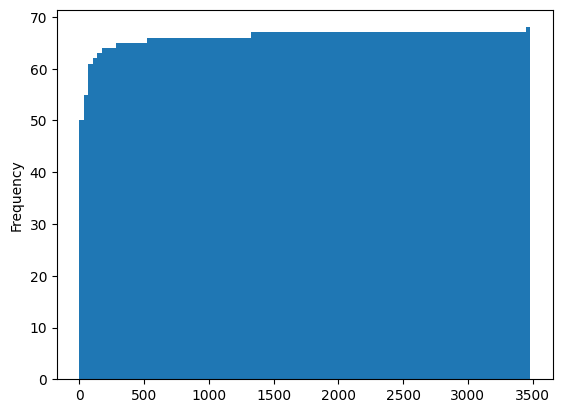

In [94]:
p = gene_counts_df[["gene", "geneset_count"]].reset_index(drop=True).geneset_count.value_counts().plot(kind="hist", bins=100, cumulative=True) #xscale="log")


<Axes: xlabel='geneset_count'>

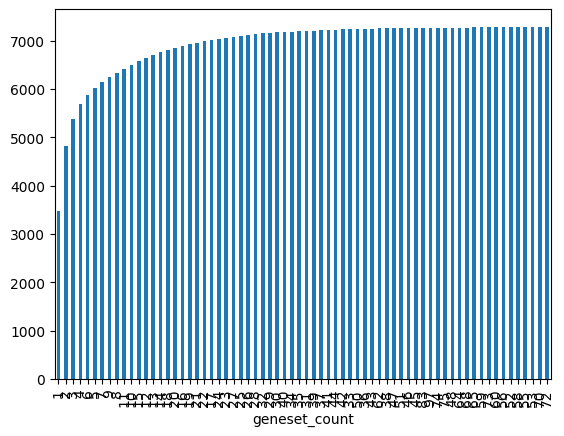

In [76]:
gene_counts_df[["gene", "geneset_count"]].reset_index(drop=True).geneset_count.value_counts().cumsum().plot(kind="bar")

# the genes that appear in a least X% of tot genesets
# TODO
    # why? maybe thake only the last groups

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7fe1ad325010>>
Traceback (most recent call last):
  File "/home/gdallagl/.pyenv/versions/esm2_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


<Axes: >

Error in callback <function _draw_all_if_interactive at 0x7fe07a178c20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

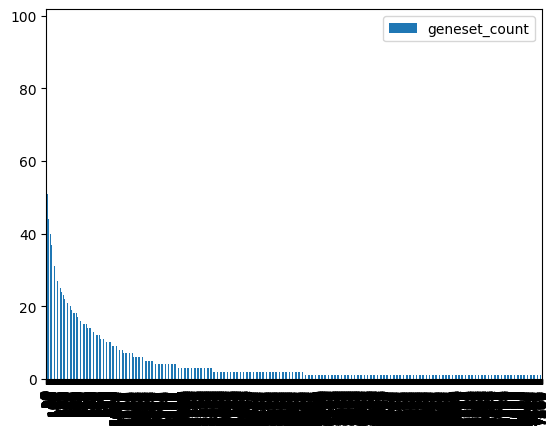

In [63]:
gene_counts_df[["gene", "geneset_count"]].reset_index(drop=True).plot(kind="bar")

## Mark as "ambiguos" genes with too few Gene Sets

In [95]:
# give a label to gene that overcome the thr
gene_counts_df["label"] = gene_counts_df.geneset_count.apply(lambda x: 'positive' if x > MIN_FREQ_AMBIGOUS else 'ambigous')

# create a label for later
gene_counts_df["is_guaranteed"] = False

display(gene_counts_df)
print(gene_counts_df.label.value_counts())

,gene,geneset_count,label,is_guaranteed
0,CDK1,97,positive,False
1,CCNB1,83,positive,False
2,PLK1,75,positive,False
3,BIRC5,74,positive,False
4,RB1,73,positive,False
...,...,...,...,...
7283,SCAI,1,ambigous,False
7284,SCML1,1,ambigous,False
7285,SERINC5,1,ambigous,False
7286,SIRPG,1,ambigous,False


label
ambigous    4829
positive    2459
Name: count, dtype: int64


In [75]:
gene_counts_df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/_old/pos_genes_freq.csv")

## Add Guaranteed genes

Add genes related to interesting field (i.e. that msut be present).

Read them from csv file.

Add them with max-freq.

In [8]:
### 1) Read spefic csv
garanted_genes_df = pd.read_csv(GUARANTEED_GENES_PATH, sep='\t')
display(garanted_genes_df.head(5))

### 2) Extarct the single gene names
all_values = garanted_genes_df.to_numpy().flatten().tolist()
all_values = [x for x in all_values if pd.notna(x)] # remove nan
all_values = list(set(all_values)) # remove duplicated
print("Number of guaranted genes: ", len(all_values))

### 3) Add them into previus df
# create a DataFrame for new genes
new_genes_df = pd.DataFrame({
    'gene': all_values,
    'geneset_count': max(gene_counts_df.geneset_count), # Use as Freq the max (as these genes are guaranted)
    'label': "positive",
    "is_guaranteed": True
})

# append to existing gene_frequency_df
gene_frequency_df = pd.concat([gene_counts_df, new_genes_df], ignore_index=True)

# ATTENTION: Drop duplicates, keeping **the last occurrence** (i.e., from new_genes_df) --< so gurated genes have max freq
gene_frequency_df = gene_frequency_df.drop_duplicates(subset='gene', keep='last')

# Sort and reset index
gene_frequency_df.sort_values(by=['geneset_count', 'gene'], ascending=[False, True], inplace=True)
gene_frequency_df.reset_index(drop=True, inplace=True)

display(display(gene_frequency_df.head(5)))


,GBM_G1S,GBM_G2M,H3_K27M_CC,IDH_O_G1S,IDH_O_G2M,Melanoma_G1S,Melanoma_G2M
0,RRM2,CCNB1,UBE2T,MCM5,HMGB2,MCM5,HMGB2
1,PCNA,CDC20,HMGB2,PCNA,CDK1,PCNA,CDK1
2,KIAA0101,CCNB2,TYMS,TYMS,NUSAP1,TYMS,NUSAP1
3,HIST1H4C,PLK1,MAD2L1,FEN1,UBE2C,FEN1,UBE2C
4,MLF1IP,CCNA2,CDK1,MCM2,BIRC5,MCM2,BIRC5


Number of guaranted genes:  146


,gene,geneset_count,label,is_guaranteed
0,ANLN,97,positive,True
1,ANP32E,97,positive,True
2,ARHGAP11A,97,positive,True
3,ARL6IP1,97,positive,True
4,ASF1B,97,positive,True


None

# ----

In [9]:
# # FREEMAN

# df_cc = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/cc_dataset_freeman/mjy063_supplementary_table_s3.csv")
# df_cc = df_cc[
#     (df_cc.Gene_type == "protein-coding") &
#     (df_cc["Cell cycle association"] == "Known") 
# ]

# gene_frequency_df = df_cc[["HGNC_gene_symbol"]].rename(columns={"HGNC_gene_symbol": "gene"})
# gene_frequency_df["geneset_count"] = 100
# gene_frequency_df["label"] = "positive"
# gene_frequency_df["is_guaranteed"] = True
# gene_frequency_df


# ----

In [10]:
# create lists of genes
ambiguos_genes = set(gene_frequency_df[gene_frequency_df.label == "ambigous"].gene)
positive_genes = set(gene_frequency_df[gene_frequency_df.label == "positive"].gene)

print(gene_frequency_df.is_guaranteed.value_counts())
print("\nTotal genes of cell cycle program:", gene_frequency_df.gene.nunique())

is_guaranteed
False    7148
True      146
Name: count, dtype: int64

Total genes of cell cycle program: 7294


# Create mapping positive-gene --> geneset-freq

In [11]:
# make postive gene-freq mapping
    # Filter ONLY positive genes
positive_genes_df = gene_frequency_df[gene_frequency_df["label"] == "positive"]
# Create a mapping: gene -> frequency
positive_gene_freq_map = dict(zip(positive_genes_df["gene"], positive_genes_df["geneset_count"]))
positive_gene_freq_map

{'ANLN': 97,
 'ANP32E': 97,
 'ARHGAP11A': 97,
 'ARL6IP1': 97,
 'ASF1B': 97,
 'ATAD2': 97,
 'AURKA': 97,
 'AURKB': 97,
 'BIRC5': 97,
 'BLM': 97,
 'BRIP1': 97,
 'BUB1': 97,
 'BUB1B': 97,
 'CASP8AP2': 97,
 'CBX5': 97,
 'CCNA2': 97,
 'CCNB1': 97,
 'CCNB2': 97,
 'CCNE2': 97,
 'CDC20': 97,
 'CDC25B': 97,
 'CDC25C': 97,
 'CDC45': 97,
 'CDC6': 97,
 'CDCA2': 97,
 'CDCA3': 97,
 'CDCA5': 97,
 'CDCA7': 97,
 'CDCA8': 97,
 'CDK1': 97,
 'CENPA': 97,
 'CENPE': 97,
 'CENPF': 97,
 'CENPK': 97,
 'CENPM': 97,
 'CHAF1B': 97,
 'CKAP2': 97,
 'CKAP2L': 97,
 'CKAP5': 97,
 'CKS1B': 97,
 'CKS2': 97,
 'CLSPN': 97,
 'CTCF': 97,
 'DLGAP5': 97,
 'DSCC1': 97,
 'DTL': 97,
 'DUT': 97,
 'E2F8': 97,
 'ECT2': 97,
 'EXO1': 97,
 'FAM64A': 97,
 'FANCI': 97,
 'FEN1': 97,
 'FOXM1': 97,
 'G2E3': 97,
 'GAS2L3': 97,
 'GINS2': 97,
 'GMNN': 97,
 'GPSM2': 97,
 'GTSE1': 97,
 'H2AFZ': 97,
 'HELLS': 97,
 'HIST1H4C': 97,
 'HJURP': 97,
 'HMGB2': 97,
 'HMGB3': 97,
 'HMGN2': 97,
 'HMMR': 97,
 'HN1': 97,
 'KIAA0101': 97,
 'KIF11': 97,
 'KIF

# Create Protein-Gene-Uniref50 df


In [12]:
uniprot_id_mapping_df = pd.read_csv(MAPPING_PATH, sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])
#print(uniprot_id_mapping_df.ID_Type.unique())
uniprot_id_mapping_df.head(2)

,UniProtKB_Accession,ID_Type,External_ID
0,P31946,UniProtKB-ID,1433B_HUMAN
1,P31946,Gene_Name,YWHAB


In [13]:
# select protein and gene IDs
protein2uniref = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"].copy()
gene2protein = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "Gene_Name"].copy()

# filter only allowed proteins
protein2uniref = protein2uniref[protein2uniref.UniProtKB_Accession.isin(allowed_proteins)]
gene2protein = gene2protein[gene2protein.UniProtKB_Accession.isin(allowed_proteins)]

# raname
protein2uniref = (
    protein2uniref
    .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "UniRef50_Cluster"})
    .drop(columns=["ID_Type"])
)
gene2protein = (
    gene2protein
    .rename(columns={"UniProtKB_Accession": "protein", "External_ID": "gene"})
    .drop(columns=["ID_Type"])
)
display(protein2uniref)
display(gene2protein)

,protein,UniRef50_Cluster
13,P31946,UniRef50_P31946
131,P62258,UniRef50_P62258
273,Q04917,UniRef50_Q04917
377,P61981,UniRef50_P61981
541,P31947,UniRef50_P31947
...,...,...
1868137,Q6WRX3,UniRef50_Q6WRX3
1868192,Q9C0D3,UniRef50_Q9C0D3
1868268,Q15942,UniRef50_Q15942
1868355,O43149,UniRef50_O43149


,protein,gene
1,P31946,YWHAB
120,P62258,YWHAE
251,Q04917,YWHAH
342,P61981,YWHAG
470,P31947,SFN
...,...,...
1868129,Q6WRX3,ZYG11A
1868183,Q9C0D3,ZYG11B
1868246,Q15942,ZYX
1868344,O43149,ZZEF1


In [14]:
# Add gene name to protein
uniref_df = pd.merge(how="inner", left=gene2protein, right=protein2uniref, on="protein")

# ATTENTION
    # protein --> mapped to multiple genes 
        # (ex. special gene mutation, but same protein name)
    # gene --> mapped to multiple protein
        # (ex. isofoms) --> took care before (allowed_gene filtering)
        # (ex. differt proteins)
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())

duplicated_proteins = uniref_df[uniref_df["protein"].duplicated(keep=False)]
duplicated_genes = uniref_df[uniref_df["gene"].duplicated(keep=False)]

display(duplicated_genes)
display(duplicated_proteins)

number duplciated proteins:  127
number duplciated genes:  83


,protein,gene,UniRef50_Cluster
558,O43687,AKAP7,UniRef50_O43687
559,Q9P0M2,AKAP7,UniRef50_Q6JP77
611,P84996,GNAS,UniRef50_Q6R0H6
896,C0HMD6,PIDD1,UniRef50_C0HMD6
932,F7VJQ1,PRNP,UniRef50_F7VJQ1
...,...,...,...
19243,P63131,ERVK-7,UniRef50_Q9Y6I0
19244,P63122,ERVK-8,UniRef50_P10265
19245,P63127,ERVK-9,UniRef50_P63128
19932,Q70YC5,ZNF365,UniRef50_Q70YC5


,protein,gene,UniRef50_Cluster
1044,Q8IVW1,ARL17A,UniRef50_Q8IVW1
1045,Q8IVW1,ARL17B,UniRef50_Q8IVW1
1676,Q9H3K6,BOLA2,UniRef50_Q9H3K6
1677,Q9H3K6,BOLA2B,UniRef50_Q9H3K6
2284,Q8NHW4,CCL4L1,UniRef50_P10147
...,...,...,...
19153,O14599,BPY2,UniRef50_O14599
19154,O14599,BPY2B,UniRef50_O14599
19155,O14599,BPY2C,UniRef50_O14599
19467,Q9HD64,XAGE1A,UniRef50_Q9HD64


In [15]:
# Subset protein with mutliple gene to have only one gene
    # take it randomly
    # BUT sample before a gene from "postiev_gene" if rpesent

# add a helper column to mark whether the gene is "positive"
uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)

# sort so that positive ones come first for each protein
uniref_df = uniref_df.sort_values(["protein", "is_positive"], ascending=[True, False])

# drop duplicates, keeping the first (which will be the positive one if it exists)
    # ATTENTION: if there are multiple postive genes, you will lose some !!!
uniref_df = uniref_df.drop_duplicates(subset="protein", keep="first")

# drop the helper column if no longer needed
uniref_df = uniref_df.drop(columns=["is_positive"])

In [16]:
# Subset genes with mutliple protein to have only one protein
    # take it randomly
    # BUT sample before a gene from "postiev_gene" if rpesent
uniref_df["is_positive"] = uniref_df["gene"].isin(positive_genes)
uniref_df = uniref_df.sort_values(["gene", "is_positive"], ascending=[True, False])
uniref_df = uniref_df.drop_duplicates(subset="gene", keep="first")
uniref_df = uniref_df.drop(columns=["is_positive"])

In [17]:
# final check
print("number duplciated proteins: ", uniref_df.protein.duplicated().sum()) # no protesin mapped to multiple genes
print("number duplciated genes: ", uniref_df.gene.duplicated().sum())
uniref_df

number duplciated proteins:  0
number duplciated genes:  0


,protein,gene,UniRef50_Cluster
72,P04217,A1BG,UniRef50_P04217
73,Q9NQ94,A1CF,UniRef50_Q9NQ94
83,P01023,A2M,UniRef50_P01023
84,A8K2U0,A2ML1,UniRef50_A8K2U0
86,U3KPV4,A3GALT2,UniRef50_U3KPV4
...,...,...,...
20389,Q6WRX3,ZYG11A,UniRef50_Q6WRX3
20390,Q9C0D3,ZYG11B,UniRef50_Q9C0D3
20391,Q15942,ZYX,UniRef50_Q15942
20392,O43149,ZZEF1,UniRef50_O43149


# Create Cluster Uniref50 df

,UniRef50_Cluster,protein,gene,n_proteins,n_genes
11076,UniRef50_Q86YD7,"[Q86YD7, A6NDY2, A0A8V8TNH8, A8MX19, P0C7W8, P...","[FAM90A1, FAM90A10, FAM90A11, FAM90A12, FAM90A...",22,22
9864,UniRef50_Q6R6M4,"[Q7RTZ2, C9JJH3, C9JVI0, C9JPN9, C9JLJ4, C9J2P...","[USP17L1, USP17L10, USP17L11, USP17L12, USP17L...",19,19
7023,UniRef50_Q13066,"[P0DTW1, A6NGK3, A1L429, P0CL80, P0CL81, A6NDE...","[GAGE1, GAGE10, GAGE12B, GAGE12F, GAGE12G, GAG...",17,17
18731,UniRef50_Q9Y5E9,"[Q9UN67, Q9Y5F2, Q9Y5F1, Q9Y5F0, Q9Y5E9, Q9Y5E...","[PCDHB10, PCDHB11, PCDHB12, PCDHB13, PCDHB14, ...",13,13
9125,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...","[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20, PRAME...",13,13
...,...,...,...,...,...
6525,UniRef50_Q01726,[Q01726],[MC1R],1,1
6524,UniRef50_Q01718,[Q01718],[MC2R],1,1
6523,UniRef50_Q01705,[P46531],[NOTCH1],1,1
6522,UniRef50_Q01668,[Q01668],[CACNA1D],1,1


<Axes: xlabel='n_proteins'>

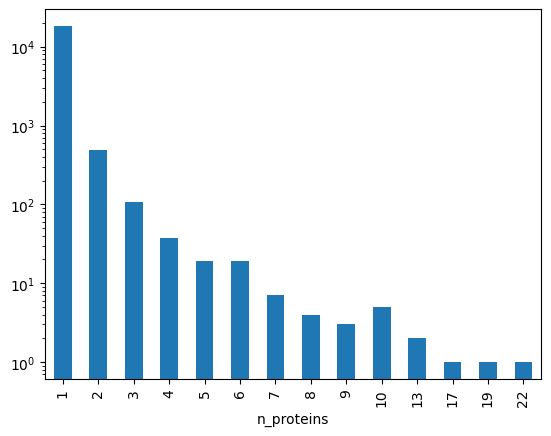

In [18]:
# create a df with clusters as entry
uniref_df = uniref_df.groupby('UniRef50_Cluster').agg({
    'protein': list,
    'gene': list,
}).reset_index()

# count
uniref_df["n_proteins"] = uniref_df.protein.apply(len)
uniref_df["n_genes"] = uniref_df.gene.apply(len)
uniref_df.sort_values(by="n_proteins", inplace=True, ascending=False)

# plot
display(uniref_df)
uniref_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True)

In [19]:
# CHECK: genes or proteins shared acorss clusters

# explode the lists into one row per (cluster, protein)
protein_cluster_map = uniref_df.explode("protein")[["UniRef50_Cluster", "protein"]].dropna()
gene_cluster_map = uniref_df.explode("gene")[["UniRef50_Cluster", "gene"]].dropna()

# group by protein and collect all clusters that contain it
protein_to_clusters = protein_cluster_map.groupby("protein")["UniRef50_Cluster"].unique()
gene_to_clusters = gene_cluster_map.groupby("gene")["UniRef50_Cluster"].unique()

# keep only proteins that occur in >1 cluster
shared_proteins = protein_to_clusters[protein_to_clusters.apply(len) > 1]
shared_genes = gene_to_clusters[gene_to_clusters.apply(len) > 1]

print(f"{len(shared_proteins)} proteins are shared between clusters")
display(shared_proteins.head())
print(f"{len(shared_genes)} genes are shared between clusters")
display(shared_genes.head())


0 proteins are shared between clusters


Series([], Name: UniRef50_Cluster, dtype: object)

0 genes are shared between clusters


Series([], Name: UniRef50_Cluster, dtype: object)

## Mark positive genes and clusters

cluster_label
negative    16634
positive     2353
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive
2652,UniRef50_O95997,"[O95997, Q9NZH5, Q9NZH4]","[PTTG1, PTTG2, PTTG3P]",3,3,positive,"[O95997, Q9NZH5, Q9NZH4]","[PTTG1, PTTG2, PTTG3P]",3
3447,UniRef50_P0DP23,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,3,positive,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3
3432,UniRef50_P0DMV8,"[P0DMV8, P0DMV9, P34931]","[HSPA1A, HSPA1B, HSPA1L]",3,3,positive,"[P0DMV8, P0DMV9, P34931]","[HSPA1A, HSPA1B, HSPA1L]",3
2908,UniRef50_P04000,"[P04000, P04001, P0DN77, P0DN78]","[OPN1LW, OPN1MW, OPN1MW2, OPN1MW3]",4,4,positive,"[P04000, P04001, P0DN77]","[OPN1LW, OPN1MW, OPN1MW2]",3
6168,UniRef50_P62807,"[P33778, P62807, P58876]","[H2BC3, H2BC4, H2BC5]",3,3,positive,"[P33778, P62807, P58876]","[H2BC3, H2BC4, H2BC5]",3


(18987, 9)

<Axes: xlabel='n_genes_positive'>

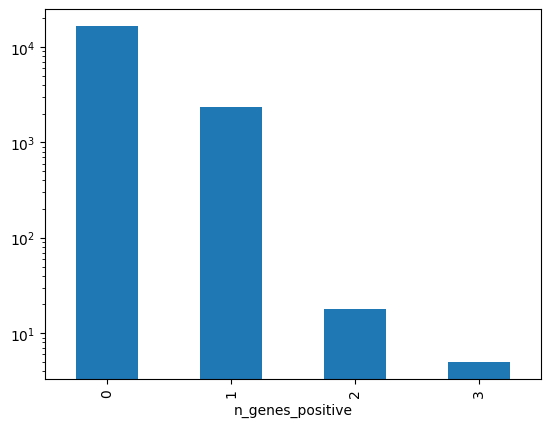

In [20]:
# Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
uniref_df["cluster_label"] = uniref_df["gene"].apply(
    lambda gene_list: "positive" 
    if any(g in positive_genes for g in gene_list)
    else "negative"
)

# plost how many postive genesets
print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)

#########

# create list of genes AND CORREPSONDET prots that are postive (from above)

# unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
    # maintain if proteins comes form psotive gene
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if g in positive_genes],
        [g for g in row["gene"] if g in positive_genes]
    ),
    axis=1
))
uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(uniref_df.head(5))
display(uniref_df.shape)
uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

In [21]:
# give probablities to be samped to each protein
uniref_df["logits"] = uniref_df["genes_positive"].apply(
    lambda gene_list: [positive_gene_freq_map.get(g, 0) for g in gene_list]
)
def safe_softmax(logits):
    if len(logits) == 0:
        return []  # return empty list if no logits
    return softmax(logits).tolist()  # convert numpy array to list
uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

uniref_df.head(2)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs
2652,UniRef50_O95997,"[O95997, Q9NZH5, Q9NZH4]","[PTTG1, PTTG2, PTTG3P]",3,3,positive,"[O95997, Q9NZH5, Q9NZH4]","[PTTG1, PTTG2, PTTG3P]",3,"[97, 7, 4]","[1.0, 8.194012623990515e-40, 4.079558667177560..."
3447,UniRef50_P0DP23,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,3,positive,"[P0DP23, P0DP24, P0DP25]","[CALM1, CALM2, CALM3]",3,"[9, 11, 9]","[0.10650697891920073, 0.7869860421615984, 0.10..."


In [22]:
# Create list of putative negative genes/protein        
    # ATTENTION; putatove = neither postive neither ambigous
gene_to_exclude = ambiguos_genes.union(positive_genes)

uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["protein"], row["gene"]) if g not in gene_to_exclude],
        [g for g in row["gene"] if g not in gene_to_exclude]
    ),
    axis=1
))
# count
uniref_df["n_putative_negative_genes"] = uniref_df.putative_negative_genes.apply(len)

# ATTENTION: same NEGATIVE clusters coudl have 0 proteins
# necause all proteins are postive OR ambigous so nothing left to sample as negative)

display(uniref_df.tail(5))


,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes
6527,UniRef50_Q01780,[Q01780],[EXOSC10],1,1,negative,[],[],0,[],[],[],[],0
6502,UniRef50_Q01432,[Q01432],[AMPD3],1,1,negative,[],[],0,[],[],[],[],0
6501,UniRef50_Q01415,[Q01415],[GALK2],1,1,negative,[],[],0,[],[],[Q01415],[GALK2],1
6510,UniRef50_Q01523,[Q01523],[DEFA5],1,1,negative,[],[],0,[],[],[Q01523],[DEFA5],1
6540,UniRef50_Q01959,[Q01959],[SLC6A3],1,1,negative,[],[],0,[],[],[Q01959],[SLC6A3],1


# Plotting positive genes per cluster

fraction_positive
0.000000    16634
0.052632        1
0.058824        1
0.142857        1
0.250000        2
0.333333        5
0.500000       39
0.750000        1
1.000000     2303
Name: count, dtype: int64


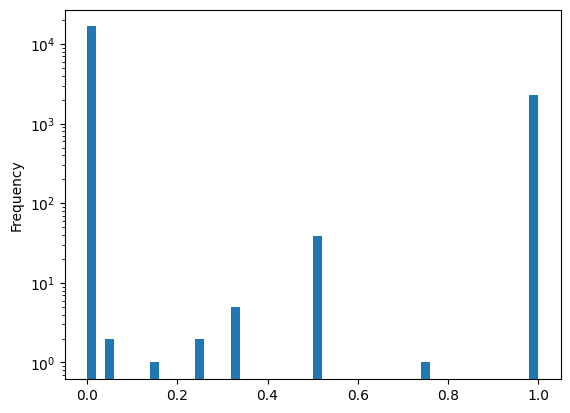

In [23]:
# FRACTION OF CLUSTER OCCUPIED BY POSITIVE GENES
uniref_df["fraction_positive"] = uniref_df.n_genes_positive / uniref_df.n_genes
uniref_df.sort_values(by="fraction_positive", inplace=True, ascending=False)

# hsit
uniref_df.fraction_positive.plot(kind="hist", logy=True, bins=50)
print(uniref_df.fraction_positive.value_counts().sort_index())


In [24]:
# Perform only on clusters wiht enogh cells
uniref_df_big_clusters = uniref_df[uniref_df.n_genes >= 5].copy()

# Calculate total genes and total positive genes across all clusters
total_genes = uniref_df_big_clusters['n_genes'].sum()
total_positive = uniref_df_big_clusters['n_genes_positive'].sum()

# Apply to each cluster - get both prob and pvalue in one go
results = uniref_df_big_clusters.apply(
    lambda row: pd.Series(dataf.per_cluster_hypergeom_test(row, total_genes, total_positive)), 
    axis=1
)
uniref_df_big_clusters['enrichment_prob'] = results[0]
uniref_df_big_clusters['enrichment_pvalue'] = results[1]

# Sort by p-value to see most significant clusters
uniref_df_results = uniref_df_big_clusters.sort_values('enrichment_pvalue')

print("Top enriched clusters:")
display(uniref_df_results[['n_genes', 'n_genes_positive', 'fraction_positive', 
                          'enrichment_prob', 'enrichment_pvalue']])

# Apply multiple testing correction (Bonferroni)
n_tests = len(uniref_df_big_clusters)
alpha = 0.05
bonferroni_threshold = alpha / n_tests

uniref_df_big_clusters['significant'] = uniref_df_big_clusters['enrichment_pvalue'] < bonferroni_threshold

print(f"\nNumber of significantly enriched clusters (Bonferroni corrected): {uniref_df_big_clusters['significant'].sum()}")
print(f"Bonferroni threshold: {bonferroni_threshold:.2e}")


Top enriched clusters:


,n_genes,n_genes_positive,fraction_positive,enrichment_prob,enrichment_pvalue
2094,7,1,0.142857,0.045328,0.045945
7023,17,1,0.058824,0.105175,0.109106
9864,19,1,0.052632,0.116466,0.121394
14869,6,0,0.000000,0.960531,1.000000
7727,6,0,0.000000,0.960531,1.000000
...,...,...,...,...,...
14536,6,0,0.000000,0.960531,1.000000
624,10,0,0.000000,0.934804,1.000000
466,10,0,0.000000,0.934804,1.000000
1910,10,0,0.000000,0.934804,1.000000



Number of significantly enriched clusters (Bonferroni corrected): 0
Bonferroni threshold: 8.06e-04


# Create Dataset

## Positive class sampling


In [25]:
# Filter only positive clusters
uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

if not TAKE_ALL_POSITIVE_GENES:
    MIN_SAMPLE_N_POSITIVE = uniref_df_pos.n_genes_positive.max()

uniref_df_pos["proteins_sampled"], uniref_df_pos["genes_sampled"] = zip(
    *uniref_df_pos.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=MIN_SAMPLE_N_POSITIVE, 
            gene_col="genes_positive",  # ATTENTION_: sample from correct columns
            prot_col="proteins_positive", 
            probs_col="probs")
)
uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

display(uniref_df_pos.head(2))
print(uniref_df_pos.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
13516,UniRef50_Q92791,[Q92791],[P3H4],1,1,positive,[Q92791],[P3H4],1,[3],[1.0],[],[],0,1.0,[Q92791],[P3H4],1
13515,UniRef50_Q92785,[Q92785],[DPF2],1,1,positive,[Q92785],[DPF2],1,[15],[1.0],[],[],0,1.0,[Q92785],[DPF2],1


(2353, 18)


## Negative class sampling

In [26]:
# Filter only positive clusters
    # sample from clusters that do nto contain psotive (negative label of before)
    # 
uniref_df_neg = uniref_df[(uniref_df.n_putative_negative_genes > 0) & (uniref_df.cluster_label == "negative")].copy() 

uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
    *uniref_df_neg.apply(
            dataf.sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=MIN_SAMPLE_N_POSITIVE, 
            gene_col="putative_negative_genes", 
            prot_col="putative_negative_proteins", 
            probs_col=None # uniform
            )
)
uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

display(uniref_df_neg.head())
print(uniref_df_neg.shape)

,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled
12903,UniRef50_Q8TD07,[Q8TD07],[RAET1E],1,1,negative,[],[],0,[],[],[Q8TD07],[RAET1E],1,0.0,[Q8TD07],[RAET1E],1
12888,UniRef50_Q8TCT6,[Q8TCT6],[SPPL3],1,1,negative,[],[],0,[],[],[Q8TCT6],[SPPL3],1,0.0,[Q8TCT6],[SPPL3],1
1929,UniRef50_O60882,[O60882],[MMP20],1,1,negative,[],[],0,[],[],[O60882],[MMP20],1,0.0,[O60882],[MMP20],1
1898,UniRef50_O60741,[O60741],[HCN1],1,1,negative,[],[],0,[],[],[O60741],[HCN1],1,0.0,[O60741],[HCN1],1
1931,UniRef50_O60884,[O60884],[DNAJA2],1,1,negative,[],[],0,[],[],[O60884],[DNAJA2],1,0.0,[O60884],[DNAJA2],1


(12053, 18)


## Make dataset

Final df shoudl be:
- | Cluster | protein name | label | seq |

In [27]:
# add labels
uniref_df_pos["label_single_prot"] = 1
uniref_df_neg["label_single_prot"] = 0

# merge --> each entry is a cluster
dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
display(dataset_df.head())
display(dataset_df.shape)



,UniRef50_Cluster,protein,gene,n_proteins,n_genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,fraction_positive,proteins_sampled,genes_sampled,n_proteins_sampled,label_single_prot
13516,UniRef50_Q92791,[Q92791],[P3H4],1,1,positive,[Q92791],[P3H4],1,[3],[1.0],[],[],0,1.0,[Q92791],[P3H4],1,1
13515,UniRef50_Q92785,[Q92785],[DPF2],1,1,positive,[Q92785],[DPF2],1,[15],[1.0],[],[],0,1.0,[Q92785],[DPF2],1,1
6461,UniRef50_Q00537,[Q00537],[CDK17],1,1,positive,[Q00537],[CDK17],1,[7],[1.0],[],[],0,1.0,[Q00537],[CDK17],1,1
13512,UniRef50_Q92782,[Q92782],[DPF1],1,1,positive,[Q92782],[DPF1],1,[15],[1.0],[],[],0,1.0,[Q92782],[DPF1],1,1
13135,UniRef50_Q8WUM4,[Q8WUM4],[PDCD6IP],1,1,positive,[Q8WUM4],[PDCD6IP],1,[16],[1.0],[],[],0,1.0,[Q8WUM4],[PDCD6IP],1,1


(14406, 19)

In [28]:
# smaller df
cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
                'genes_sampled', 'label_single_prot']
dataset_df_small = dataset_df[cols_to_keep].copy()
display(dataset_df_small)

# Create a new DataFrame where each row corresponds to a (protein, gene) pair
rows = []
for _, row in dataset_df_small.iterrows():
    cluster = row["UniRef50_Cluster"]
    label = row["label_single_prot"]
    proteins = row["proteins_sampled"]
    genes = row["genes_sampled"]

    # zip ensures 1-to-1 pairing between proteins and genes
    for prot, gene in zip(proteins, genes):
        rows.append({
            "UniRef50_Cluster": cluster,
            "protein": prot,
            "gene": gene,
            "label": label
        })

df_long = pd.DataFrame(rows)

print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
print(df_long.protein.nunique(), "/ ~20000")

# checj fro duplcates
print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

df_long

,UniRef50_Cluster,proteins_sampled,genes_sampled,label_single_prot
13516,UniRef50_Q92791,[Q92791],[P3H4],1
13515,UniRef50_Q92785,[Q92785],[DPF2],1
6461,UniRef50_Q00537,[Q00537],[CDK17],1
13512,UniRef50_Q92782,[Q92782],[DPF1],1
13135,UniRef50_Q8WUM4,[Q8WUM4],[PDCD6IP],1
...,...,...,...,...
13868,UniRef50_Q96CW6,[Q96CW6],[SLC7A6OS],0
13869,UniRef50_Q96CW9,[Q96CW9],[NTNG2],0
13871,UniRef50_Q96CX3,[Q96CX3],[ZNF501],0
13873,UniRef50_Q96D03,[Q96D03],[DDIT4L],0


ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
15116 / ~20000

Duplicated rows/proteins:  0


,UniRef50_Cluster,protein,gene,label
0,UniRef50_Q92791,Q92791,P3H4,1
1,UniRef50_Q92785,Q92785,DPF2,1
2,UniRef50_Q00537,Q00537,CDK17,1
3,UniRef50_Q92782,Q92782,DPF1,1
4,UniRef50_Q8WUM4,Q8WUM4,PDCD6IP,1
...,...,...,...,...
15111,UniRef50_Q96CW6,Q96CW6,SLC7A6OS,0
15112,UniRef50_Q96CW9,Q96CW9,NTNG2,0
15113,UniRef50_Q96CX3,Q96CX3,ZNF501,0
15114,UniRef50_Q96D03,Q96D03,DDIT4L,0


# Assure 1:3 ratio in postive and negative class
After this sampling you will have (done LATER in notebook)
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Subsample the remaining cluster to have a final ratio 1:3

In [29]:
# list of smpled positve proteins
positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

# list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
    # ATTENTUON: check no ptortien in mixed clusters
proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
print("priteins in mixed clusters:", len(proteins_in_mixed_clusters))
proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

# proteins to NOT remove
proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

# give col
df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)

df_long

priteins in mixed clusters: 0


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_Q92791,Q92791,P3H4,1,False
1,UniRef50_Q92785,Q92785,DPF2,1,False
2,UniRef50_Q00537,Q00537,CDK17,1,False
3,UniRef50_Q92782,Q92782,DPF1,1,False
4,UniRef50_Q8WUM4,Q8WUM4,PDCD6IP,1,False
...,...,...,...,...,...
15111,UniRef50_Q96CW6,Q96CW6,SLC7A6OS,0,True
15112,UniRef50_Q96CW9,Q96CW9,NTNG2,0,True
15113,UniRef50_Q96CX3,Q96CX3,ZNF501,0,True
15114,UniRef50_Q96D03,Q96D03,DDIT4L,0,True


In [30]:
# decide fraction to susample

# Number of positive proteins
n_positive = df_long[df_long["label"] == 1].shape[0]
# Number desidered negative
n_desired_negatives = n_positive * NEGATIVE_CLASS_MULT
# Removable (negative) proteins
removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
# Determine fraction to subsample
frac_to_sample = n_desired_negatives / len(removable_negatives)
frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

frac_to_sample

0.5608951707891637

In [31]:

# susample
removable = df_long[df_long["can_be_removed"]]
keep = df_long[~df_long["can_be_removed"]]

subsampled_removable = removable.sample(frac=frac_to_sample, random_state=SEED)

df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

print(df_subsampled.label.value_counts())
df_subsampled

label
0    7143
1    2381
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_Q92791,Q92791,P3H4,1,False
1,UniRef50_Q92785,Q92785,DPF2,1,False
2,UniRef50_Q00537,Q00537,CDK17,1,False
3,UniRef50_Q92782,Q92782,DPF1,1,False
4,UniRef50_Q8WUM4,Q8WUM4,PDCD6IP,1,False
...,...,...,...,...,...
9519,UniRef50_Q15835,Q15835,GRK1,0,True
9520,UniRef50_A6NMU1,A6NMU1,OR52A4P,0,True
9521,UniRef50_Q8WUQ7,Q8WUQ7,CACTIN,0,True
9522,UniRef50_P57729,P57729,RAB38,0,True


## Give Seq


In [32]:
### create df to join
join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# join
    # ATTNETION: we shoudl NOT lose any col
long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# drp cols
long_df_seq.drop(columns=["can_be_removed", "Entry"], inplace=True)

long_df_seq

,UniRef50_Cluster,protein,gene,label,sequence
0,UniRef50_Q92791,Q92791,P3H4,1,MARVAWGLLWLLLGSAGAQYEKYSFRGFPPEDLMPLAAAYGHALEQ...
1,UniRef50_Q92785,Q92785,DPF2,1,MAAVVENVVKLLGEQYYKDAMEQCHNYNARLCAERSVRLPFLDSQT...
2,UniRef50_Q00537,Q00537,CDK17,1,MKKFKRRLSLTLRGSQTIDESLSELAEQMTIEENSSKDNEPIVKNG...
3,UniRef50_Q92782,Q92782,DPF1,1,MATVIPGPLSLGEDFYREAIEHCRSYNARLCAERSLRLPFLDSQTG...
4,UniRef50_Q8WUM4,Q8WUM4,PDCD6IP,1,MATFISVQLKKTSEVDLAKPLVKFIQQTYPSGGEEQAQYCRAAEEL...
...,...,...,...,...,...
9519,UniRef50_Q15835,Q15835,GRK1,0,MDFGSLETVVANSAFIAARGSFDGSSSQPSRDKKYLAKLKLPPLSK...
9520,UniRef50_A6NMU1,A6NMU1,OR52A4P,0,MALPITNGTLFMPFVLTFIGIPGFESVQCWIGIPFCATYVIALIGN...
9521,UniRef50_Q8WUQ7,Q8WUQ7,CACTIN,0,MGRDTRSRSRSAGRRGRRRQSQSGSRSRSRSHGRRNRRRREDEGRR...
9522,UniRef50_P57729,P57729,RAB38,0,MQAPHKEHLYKLLVIGDLGVGKTSIIKRYVHQNFSSHYRATIGVDF...


## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. **based on cluster**
    - Put proteins coming from same cluster in different sets or not

In [33]:
# split by cluster __< no data elaskage
# chekc that there ar eno clusters wiht mixed labesl
proteins_in_mixed_clusters

set()

In [34]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- group-level stratified split ---

# pslit by cluster and then ive back set-label to each row

# One representative row per UniRef50_Cluster
cluster_df = long_df_seq.groupby('UniRef50_Cluster').first().reset_index()

# Stratified split by label, but at the cluster level
    # ists of unique cluster IDs.
train_clusters, temp_clusters = train_test_split(
    cluster_df['UniRef50_Cluster'],
    test_size=0.2,
    stratify=cluster_df['label'],
    random_state=42
)

# Split the temporary set equally into validation and test
temp_labels = cluster_df.loc[cluster_df['UniRef50_Cluster'].isin(temp_clusters), 'label']
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# --- assign back to the full dataframe ---
#Every row in long_df_seq inherits its set label based on its UniRef50_Cluster
long_df_seq['set'] = ''
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(train_clusters), 'set'] = 'train'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(test_clusters), 'set'] = 'test'

# ATTENTION: ingore val
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(val_clusters), 'set'] = 'val'
long_df_seq.loc[long_df_seq['set'] == "val", 'set'] = 'test'
long_df_seq.loc[long_df_seq.loc[long_df_seq['set'] == 'test'].index[0], 'set'] = 'val' 

# Check split distribution
print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(long_df_seq)


label     0     1
set              
test   1428   476
train  5715  1904
val       0     1


,UniRef50_Cluster,protein,gene,label,sequence,set
0,UniRef50_Q92791,Q92791,P3H4,1,MARVAWGLLWLLLGSAGAQYEKYSFRGFPPEDLMPLAAAYGHALEQ...,train
1,UniRef50_Q92785,Q92785,DPF2,1,MAAVVENVVKLLGEQYYKDAMEQCHNYNARLCAERSVRLPFLDSQT...,train
2,UniRef50_Q00537,Q00537,CDK17,1,MKKFKRRLSLTLRGSQTIDESLSELAEQMTIEENSSKDNEPIVKNG...,train
3,UniRef50_Q92782,Q92782,DPF1,1,MATVIPGPLSLGEDFYREAIEHCRSYNARLCAERSLRLPFLDSQTG...,train
4,UniRef50_Q8WUM4,Q8WUM4,PDCD6IP,1,MATFISVQLKKTSEVDLAKPLVKFIQQTYPSGGEEQAQYCRAAEEL...,train
...,...,...,...,...,...,...
9519,UniRef50_Q15835,Q15835,GRK1,0,MDFGSLETVVANSAFIAARGSFDGSSSQPSRDKKYLAKLKLPPLSK...,train
9520,UniRef50_A6NMU1,A6NMU1,OR52A4P,0,MALPITNGTLFMPFVLTFIGIPGFESVQCWIGIPFCATYVIALIGN...,train
9521,UniRef50_Q8WUQ7,Q8WUQ7,CACTIN,0,MGRDTRSRSRSAGRRGRRRQSQSGSRSRSRSHGRRNRRRREDEGRR...,train
9522,UniRef50_P57729,P57729,RAB38,0,MQAPHKEHLYKLLVIGDLGVGKTSIIKRYVHQNFSSHYRATIGVDF...,train


## Save

In [35]:
long_df_seq.to_csv(FINAL_DATASET_PATH)
FINAL_DATASET_PATH

'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/dataset-cell-cycle_2:3.csv'

In [36]:
long_df_seq.to_csv('/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/dataset-cell-cycle_freeman.csv')


# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------
# ------------------------------

# YU dataset

In [37]:
from Bio import SeqIO
import pandas as pd

# Parse all sequences in the FASTA file
records = list(SeqIO.parse("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/0_class_yu_et_all.fasta", "fasta"))
data = {
    "protein": [record.id for record in records],
    "sequence": [str(record.seq) for record in records],
    "label": [0 for record in records],
}
df_neg = pd.DataFrame(data)
print(df_neg.shape)


records = list(SeqIO.parse("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/1_class_yu_et_all.fasta", "fasta"))
data = {
    "protein": [record.id for record in records],
    "sequence": [str(record.seq) for record in records],
    "label": [1 for record in records],
}
df_pos = pd.DataFrame(data)
print(df_pos.shape)

df = pd.concat([df_neg, df_pos])

df


(167, 3)
(166, 3)


,protein,sequence,label
0,N|0|training,MVWCKHCAKNVPKIRPFDGGLACDLCGRILENFNFSTDVTFVKNAA...,0
1,N|0|training,MRMLIFTYKLERYIKNKILPKILVVPDRDKYQIKGSFRRRIPYITD...,0
2,N|0|training,MPPKTPRKTAATAAAAAAEPPAPPPPPPPEEDPEQDSGPEDLPLVR...,0
3,N|0|training,MSHHSETILTAILNTKYLENGSKHKIIELPKTNIKKLIKDFLSVNS...,0
4,N|0|training,MSIAGVAAQEIRVPLKTGFLHNGRAMGNMRKTYWSSRSEFKNNFLN...,0
...,...,...,...
161,P|1|training,MELFCLEKDTVVRAQKDPNIFCDERVLQSLLTVEDRYVPQGPYFKC...,1
162,P|1|training,MAIHHHHHNHQQLQQHTSSLFDALYCDEEEKWEDDDEGEVVDEGAQ...,1
163,P|1|training,MDRASENRRLAAVGKPVPGIGEMGNRRPLRDINNLVGAPSHPSAIA...,1
164,P|1|training,MSQFAIHQDVENQVPRRGKAANTRTVTQGQKRAVLGVITNQANQPN...,1


In [38]:
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Assign splits
df['set'] = ''
df.loc[train_idx, 'set'] = 'train'
df.loc[test_idx, 'set'] = 'test'
df.loc[test_idx[0], 'set'] = 'val' #just temp
df.reset_index(drop=True, inplace=True)
df["protein"] = range(df["protein"].shape[0])

print(df.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(df)
df

label    0    1
set            
test    58   57
train  108  108
val      1    1


,protein,sequence,label,set
0,0,MVWCKHCAKNVPKIRPFDGGLACDLCGRILENFNFSTDVTFVKNAA...,0,train
1,1,MRMLIFTYKLERYIKNKILPKILVVPDRDKYQIKGSFRRRIPYITD...,0,test
2,2,MPPKTPRKTAATAAAAAAEPPAPPPPPPPEEDPEQDSGPEDLPLVR...,0,test
3,3,MSHHSETILTAILNTKYLENGSKHKIIELPKTNIKKLIKDFLSVNS...,0,train
4,4,MSIAGVAAQEIRVPLKTGFLHNGRAMGNMRKTYWSSRSEFKNNFLN...,0,train
...,...,...,...,...
328,328,MELFCLEKDTVVRAQKDPNIFCDERVLQSLLTVEDRYVPQGPYFKC...,1,test
329,329,MAIHHHHHNHQQLQQHTSSLFDALYCDEEEKWEDDDEGEVVDEGAQ...,1,train
330,330,MDRASENRRLAAVGKPVPGIGEMGNRRPLRDINNLVGAPSHPSAIA...,1,train
331,331,MSQFAIHQDVENQVPRRGKAANTRTVTQGQKRAVLGVITNQANQPN...,1,test


,protein,sequence,label,set
0,0,MVWCKHCAKNVPKIRPFDGGLACDLCGRILENFNFSTDVTFVKNAA...,0,train
1,1,MRMLIFTYKLERYIKNKILPKILVVPDRDKYQIKGSFRRRIPYITD...,0,test
2,2,MPPKTPRKTAATAAAAAAEPPAPPPPPPPEEDPEQDSGPEDLPLVR...,0,test
3,3,MSHHSETILTAILNTKYLENGSKHKIIELPKTNIKKLIKDFLSVNS...,0,train
4,4,MSIAGVAAQEIRVPLKTGFLHNGRAMGNMRKTYWSSRSEFKNNFLN...,0,train
...,...,...,...,...
328,328,MELFCLEKDTVVRAQKDPNIFCDERVLQSLLTVEDRYVPQGPYFKC...,1,test
329,329,MAIHHHHHNHQQLQQHTSSLFDALYCDEEEKWEDDDEGEVVDEGAQ...,1,train
330,330,MDRASENRRLAAVGKPVPGIGEMGNRRPLRDINNLVGAPSHPSAIA...,1,train
331,331,MSQFAIHQDVENQVPRRGKAANTRTVTQGQKRAVLGVITNQANQPN...,1,test


In [39]:
df.iloc[[332]].sequence.to_list()

['MSFAFSENPLTYDVENSQNAGPQTRKTKREDAGRGNGPQACKRAALGTLSTNVTRKQPSRAAKQSGFADGFYNYQDENAFARPAAGKSTGSCGFALPPTASQPSFSIHIDPVEPAPSRARFLKEQKPTELPLDPIGYFVTRSRKTALRTVFTLDESASPMVLDTSLSEENTAQATIEDIDNSDGVFGVPEYAEDIYEYLREAELRNRPKPGYMRKQPDITSGMRSILVDWLIEVGEEYRLHNETLYLAVSYIDRFLSQMSVLRSKLQLVGAASMFLAAKFEEIYPPEVNEFVYITDDTYTVKQVLRMEHLILKVLSFDVAVPTANAFLSRYLKAAKADSRNGTSSQYLAELTLPDCEYIKYIPSTIAAAAVCLANYTLSGTAWTPMLEKHSGYNLEDIAPCVRDLLKTFTNAPSQSQQAAQEKYKSQRYNSVSMIAAPTTLPSWL']

In [40]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/yu_et_all_cyclins.csv")

In [49]:
import pandas as pd

# 2. Use pd.read_csv with appropriate parameters
df = pd.read_csv(
    "/home/gdallagl/myworkdir/ESMSec/data/pfam/pdb_pfam_mapping.txt", 
    sep='\t', 
    comment='#', # Skips lines that start with '#' (the metadata lines)
    skipinitialspace=True # Handles any extra spaces after the tab delimiter
)

# --- Explanation of the Output ---
print(df.head())
print(f"\nDataFrame shape: {df.shape}")
df.columns

/tmp/ipykernel_50005/1473210948.py:4: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


    PDB CHAIN  PDB_START  PDB_END PFAM_ACCESSION       PFAM_NAME  \
0  101m     A         27      143        PF00042          Globin   
1  102l     A          9      152        PF00959  Phage_lysozyme   
2  102m     A         27      143        PF00042          Globin   
3  103l     A          9      154        PF00959  Phage_lysozyme   
4  103m     A         27      143        PF00042          Globin   

   AUTH_PDBRES_START AUTH_PDBRES_START_INS_CODE  AUTH_PDBRES_END  \
0               26.0                        NaN            142.0   
1                9.0                        NaN            151.0   
2               26.0                        NaN            142.0   
3                9.0                        NaN            151.0   
4               26.0                        NaN            142.0   

  AUTH_PDBRES_END_INS_CODE UNIPROT_ACCESSION  UNP_START  UNP_END  \
0                      NaN            P02185         27      143   
1                      NaN            P00720  

Index(['PDB', 'CHAIN', 'PDB_START', 'PDB_END', 'PFAM_ACCESSION', 'PFAM_NAME',
       'AUTH_PDBRES_START', 'AUTH_PDBRES_START_INS_CODE', 'AUTH_PDBRES_END',
       'AUTH_PDBRES_END_INS_CODE', 'UNIPROT_ACCESSION', 'UNP_START', 'UNP_END',
       'UNP_STR_START', 'UNP_STR_END'],
      dtype='object')

In [51]:
# --- 2. Select the necessary columns ---
# The PDB information is redundant if you only want protein-Pfam mapping
df_mapping = df[['UNIPROT_ACCESSION', 'PFAM_ACCESSION']].copy()

# --- 3. Filter for unique protein-domain pairs ---
# Remove duplicates (e.g., if the same domain is found in multiple chains/PDB structures)
df_unique = df_mapping.drop_duplicates()

# --- 4. Group by Protein and Aggregate Pfam IDs ---
# Group by the UniProt ID and aggregate all unique Pfam IDs into a list (or string)

# Option A: Aggregate into a list (better for analysis)
df_result_list = df_unique.groupby('UNIPROT_ACCESSION')['PFAM_ACCESSION'].agg(list).reset_index()
df_result_list.columns = ['Protein_Accession', 'Pfam_Families_List']

# Option B: Aggregate into a single string separated by a semicolon (easier for saving/display)
df_result_string = df_unique.groupby('UNIPROT_ACCESSION')['PFAM_ACCESSION'].agg(lambda x: ';'.join(sorted(x))).reset_index()
df_result_string.columns = ['Protein_Accession', 'Pfam_Families_String']


# --- Output the preferred DataFrame ---
print("--- DataFrame with Pfam Families as a List per Protein (Option A) ---")
print(df_result_list.head())
print(f"\nTotal unique proteins: {len(df_result_list)}")

print("\n--- DataFrame with Pfam Families as a Semicolon-Separated String (Option B) ---")
print(df_result_string.head())

--- DataFrame with Pfam Families as a List per Protein (Option A) ---
  Protein_Accession Pfam_Families_List
0            A0A003          [PF01370]
1        A0A009I821          [PF00237]
2        A0A009IHW8          [PF13676]
3        A0A009PZ93          [PF00959]
4        A0A009QSN8          [PF00237]

Total unique proteins: 64279

--- DataFrame with Pfam Families as a Semicolon-Separated String (Option B) ---
  Protein_Accession Pfam_Families_String
0            A0A003              PF01370
1        A0A009I821              PF00237
2        A0A009IHW8              PF13676
3        A0A009PZ93              PF00959
4        A0A009QSN8              PF00237


In [55]:
prot = pd.read_csv("/home/gdallagl/myworkdir/ESMSec/data/UniRef50/human_proteome.tsv", sep="\t")
prot

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Sequence
0,A0A087WZT3,unreviewed,A0A087WZT3_HUMAN,BOLA2-SMG1P6 readthrough,BOLA2-SMG1P6,Homo sapiens (Human),MELSAEYLREKLQRDLEAEHVLPSPGGVGQVRGETAASETQLGS
1,A0A087X1C5,reviewed,CP2D7_HUMAN,Cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7,Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
2,A0A087X296,unreviewed,A0A087X296_HUMAN,Prostaglandin G/H synthase 1 (EC 1.14.99.1) (C...,PTGS1,Homo sapiens (Human),MSRSLLLWFLLFLLLLPPLPVLLADPGAPTPVNPCCYYPCQHQGIC...
3,A0A0A0MQV1,unreviewed,A0A0A0MQV1_HUMAN,11-beta-hydroxysteroid dehydrogenase 1 (EC 1.1...,HSD11B1,Homo sapiens (Human),MAFMKKYLLPILGLFMAYYYYSANEEFRPEMLQGKKVIVTGASKGI...
4,A0A0A0MRG2,unreviewed,A0A0A0MRG2_HUMAN,Amyloid-beta precursor protein (ABPP) (Alzheim...,APP,Homo sapiens (Human),MFCGRLNMHMNVQNGKWDSDPSGTKTCIDTKEGILQYCQEVYPELQ...
...,...,...,...,...,...,...,...
83582,X6RLT1,unreviewed,X6RLT1_HUMAN,Negative elongation factor complex member C/D,NELFCD,Homo sapiens (Human),XEGMAGAVPGAIMDEDYYGSAAEWGDEADGGQQEDDSGEGEDDAEV...
83583,X6RLU5,unreviewed,X6RLU5_HUMAN,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4,Homo sapiens (Human),XELVREVLFDAVVTAPMEAYWTALALNMSEESEHVVDMAFLGTRAG...
83584,X6RLV5,unreviewed,X6RLV5_HUMAN,DEAD-box helicase 5,DDX5,Homo sapiens (Human),MSGYSSDRDRGRDRGFGAPRFGGSRAGPLSGKKFGNPGEKLVKKKW...
83585,X6RLY7,unreviewed,X6RLY7_HUMAN,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4,Homo sapiens (Human),MKLEFLQRKFWAATRQCSTVDGPCTQSCEDSDLDCFVIDNNGFILI...


In [59]:
df_result_string = df_result_string[df_result_string.Protein_Accession.isin(set(prot[prot.Reviewed == "reviewed"].Entry))]

df_result_string

,Protein_Accession,Pfam_Families_String
293,A0A075B6N1,PF07686
294,A0A075B6T6,PF07686
451,A0A087WSZ9,PF07686
452,A0A087WT01,PF07686
453,A0A087WT03,PF07686
...,...,...
62944,Q9Y6X8,PF00046
62945,Q9Y6X9,PF07496;PF13589;PF17942
62946,Q9Y6Y0,PF00651;PF01344
62947,Q9Y6Y1,PF01833
